In [1]:
import numpy as np
import medmnist
import time
from medmnist import INFO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
# import torchvision
from tqdm import tqdm
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
# from sklearn.linear_model import LogisticRegression

In [2]:
# set seed
torch.manual_seed(0)
np.random.seed(0)

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

showimage = torch.utils.data.DataLoader(training_data,batch_size=10000, shuffle=True)

In [3]:
train = next(iter(showimage))
images, labels = train

class 0: 


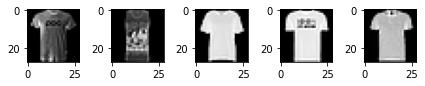

class 1: 


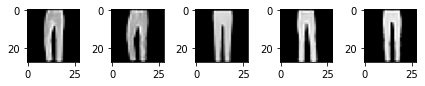

class 2: 


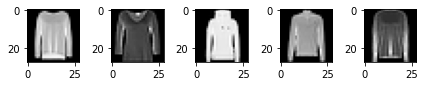

class 3: 


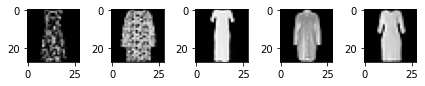

class 4: 


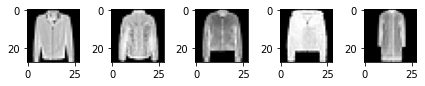

class 5: 


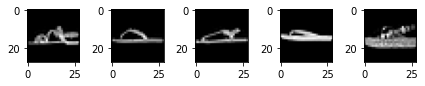

class 6: 


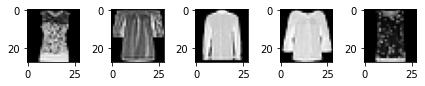

class 7: 


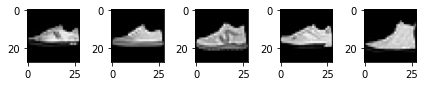

class 8: 


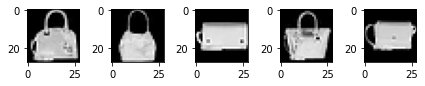

class 9: 


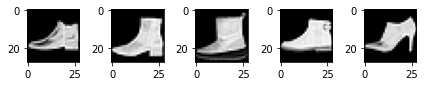

In [4]:
for k in range(10):
    j=0
    rows = 1
    columns = 5
    fig = plt.figure()
    axes = []
    print('class {}: '.format(k))
    for i in range(len(labels)):
        if labels[i] == k:
            j+=1
            axes.append(fig.add_subplot(rows, columns, j))
            plt.imshow(images[i][0,:].reshape(28,28), cmap = plt.get_cmap('gray'))
        if j == 5:
            break
    fig.tight_layout()    
    plt.show()

In [5]:
# data transformation
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5]),
    transforms.Lambda(lambda x: torch.flatten(x)) # Flatten the image
])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform = transformation
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = transformation
)

trainloader = torch.utils.data.DataLoader(training_data,batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 100)

In [6]:
# this is the input dimension but it is too slow so I just assign it
# input_dim = len(list(enumerate(trainloader))[0][1][0][0])
input_dim = 784

batch_size = 100
n_iters = 3000
epochs = int(n_iters / (len(training_data) / batch_size))
output_dim = 10
lr_rate = 0.01

In [7]:
# create pytorch logistic regression
class LogisticRegression(nn.Module):
    def __init__(self, input_dimension, classes):
        super(LogisticRegression, self).__init__()
        
        self.linear = nn.Linear(input_dimension, classes)
        
    def forward(self, x):
        output = torch.sigmoid(self.linear(x))
        return output
    
model = LogisticRegression(input_dim, output_dim)
# compute cross entropy loss because it is multi classification model
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr = lr_rate)

In [8]:
# train the model in pytorch
true_label = np.array([])
predict_label = np.array([])
train_start = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.view(-1, 28*28).requires_grad_()
        labels = labels
        
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()
        
# compute accuracy on train data
correct = 0
total = 0
for x, y in trainloader:
    x = x.view(-1, 28*28).requires_grad_()

    result = model(x)
    _, prediction = torch.max(result.data, 1)

    total += y.size(0)
    correct += (prediction==y).sum()

accuracy = 100*correct/total
train_end = time.time()
print('M1: ', accuracy.numpy(),'%')            
LR1_train_accuracy = accuracy.numpy()

# compute accuracy on test data
test_start = time.time()
correct = 0
total = 0
for x, y in testloader:
    x = x.view(-1, 28*28).requires_grad_()

    result = model(x)
    _, prediction = torch.max(result.data, 1)
    true_label = np.hstack((true_label, y.numpy()))
    predict_label = np.hstack((predict_label, prediction.numpy()))    

    total += y.size(0)
    correct += (prediction==y).sum()

accuracy = 100*correct/total
test_end = time.time()
print('M2: ', accuracy.numpy(),'%')
print('M3: ', -(train_start-train_end), ' seconds')
print('M4: ', -(test_start-test_end), ' seconds')
print('M5: ')
print('confusion matrix: ')
print(confusion_matrix(predict_label, true_label))
LR1_train_time = train_end - train_start
LR1_test_accuracy = accuracy.numpy()
LR1_test_time = test_end - test_start

M1:  74.64333 %
M2:  73.9 %
M3:  55.20384979248047  seconds
M4:  1.5218455791473389  seconds
M5: 
confusion matrix: 
[[755   5  15  36   0   0 195   0   2   0]
 [  2 896   0   6   3   0   1   0   1   0]
 [  9  15 697   4 412   0 208   0  19   0]
 [ 86  64   9 837  44   4  59   0  25   1]
 [  7  11 123  31 449   0 100   0   2   0]
 [ 27   1  12   9   9 743  36  53  36  31]
 [ 97   7 134  72  77   0 373   0  21   0]
 [  1   0   0   0   0 187   1 870  29  61]
 [ 16   1  10   5   6   6  27   0 864   1]
 [  0   0   0   0   0  60   0  77   1 906]]


In [9]:
# train the model in pytorch with l1 regularisation
true_label = np.array([])
predict_label = np.array([])
train_start = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.view(-1, 28*28).requires_grad_()
        labels = labels
        
        optimiser.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        l1_strength = 0.001
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = loss + l1_strength*l1_norm
        loss.backward()
        optimiser.step()
        
# compute accuracy on train data
correct = 0
total = 0
for x, y in trainloader:
    x = x.view(-1, 28*28).requires_grad_()

    result = model(x)
    _, prediction = torch.max(result.data, 1)
    total += y.size(0)
    correct += (prediction==y).sum()

accuracy = 100*correct/total
train_end = time.time()
print('M1: ', accuracy.numpy(),'%')            
LR2_train_accuracy = accuracy.numpy()

# compute accuracy on test data
test_start = time.time()
correct = 0
total = 0
for x, y in testloader:
    x = x.view(-1, 28*28).requires_grad_()

    result = model(x)
    _, prediction = torch.max(result.data, 1)
    true_label = np.hstack((true_label, y.numpy()))
    predict_label = np.hstack((predict_label, prediction.numpy()))    
    total += y.size(0)
    correct += (prediction==y).sum()

accuracy = 100*correct/total
test_end = time.time()
print('M2: ', accuracy.numpy(),'%')
print('M3: ', -(train_start-train_end), ' seconds')
print('M4: ', -(test_start-test_end), ' seconds')
print('M5: ')
print('confusion matrix: ')
print(confusion_matrix(predict_label, true_label))
LR2_train_time = train_end - train_start
LR2_test_accuracy = accuracy.numpy()
LR2_test_time = test_end - test_start

M1:  76.25667 %
M2:  75.34 %
M3:  56.648242473602295  seconds
M4:  1.5123412609100342  seconds
M5: 
confusion matrix: 
[[760   6  21  34   0   0 196   0   3   0]
 [  2 908   1   7   3   0   1   0   1   0]
 [  8  15 694   2 328   0 162   0  19   0]
 [ 92  61  10 853  47   5  67   0  28   1]
 [  7   6 129  26 529   0 130   0   2   0]
 [ 32   1  23  21  11 787  46  57  40  28]
 [ 79   2 114  53  77   0 366   0  20   0]
 [  0   0   0   0   0 149   2 864  23  59]
 [ 19   1   8   4   5   5  30   0 862   1]
 [  1   0   0   0   0  54   0  79   2 911]]


In [10]:
# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # original size: 1, 28, 28
        
        # convolution layer 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # (28-3+2*1)/1 + 1
        # after c1: 16, 28, 28
        
        # convolution layer 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # (14-3+2*1)/1 + 1
        # after c2: 32, 14, 14
        
        # convolution layer 3
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1) # (14-3+2*1)/1 + 1
        # after c3: 64, 14, 14
        
        # convolution layer 4
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=2) # (14-4+2*2)/2 + 1
        # after c4: 128, 8, 8
        
        # relu, adding after every convolution layer
        self.relu = nn.ReLU()
        
        # max pooling, adding after c1 and c4
        self.maxpooling = nn.MaxPool2d(kernel_size=2)
        # after max pooling 1: 16, 14, 14
        # after max pooling 2: 128, 4, 4
        
        # fully connected layer 1
        self.fc1 = nn.Linear(4*4*128, 128)
        
        # fully connected layer 2
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        # c1
        out = self.cnn1(x)
        out = self.relu(out)
        out = self.maxpooling(out)
        
        # c2
        out = self.cnn2(out)
        out = self.relu(out)
        
        # c3
        out = self.cnn3(out)
        out = self.relu(out)
        
        # c4
        out = self.cnn4(out)
        out = self.relu(out)
        out = self.maxpooling(out)
        
        # resize to (-1, 1)
        out = out.view(out.size(0), -1)
        
        # fc1
        out = self.fc1(out)
        out = self.relu(out)
        
        # fc2
        out = self.fc2(out)
        
        return out

lr_rate = 0.01
cnn_model = CNN()
cnn_loss = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr = lr_rate)

In [11]:
# data transformation
transformation = transforms.Compose([
    transforms.ToTensor(),
])

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform = transformation
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform = transformation
)

trainloader = torch.utils.data.DataLoader(training_data,batch_size=100, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 100)

In [12]:
# train the model in pytorch
true_label = np.array([])
predict_label = np.array([])
train_start = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.requires_grad_()
        labels = labels
        
        optimiser.zero_grad()
        outputs = cnn_model(images)
        loss = cnn_loss(outputs, labels)
        loss.backward()
        optimiser.step()
        
# compute accuracy on train data
correct = 0
total = 0
for x, y in trainloader:
    x = x.requires_grad_()

    result = cnn_model(x)
    _, prediction = torch.max(result.data, 1)

    total += y.size(0)
    correct += (prediction==y).sum()

accuracy = 100*correct/total
train_end = time.time()
print('M1: ', accuracy.numpy(),'%')            
CNN1_train_accuracy = accuracy.numpy()

# compute accuracy on test data
test_start = time.time()
correct = 0
total = 0
for x, y in testloader:
    x = x.requires_grad_()

    result = cnn_model(x)
    _, prediction = torch.max(result.data, 1)
    true_label = np.hstack((true_label, y.numpy()))
    predict_label = np.hstack((predict_label, prediction.numpy()))    

    total += y.size(0)
    correct += (prediction==y).sum()

accuracy = 100*correct/total
test_end = time.time()
print('M2: ', accuracy.numpy(),'%')
print('M3: ', -(train_start-train_end), ' seconds')
print('M4: ', -(test_start-test_end), ' seconds')
print('M5: ')
print('confusion matrix: ')
print(confusion_matrix(predict_label, true_label))
CNN1_train_time = train_end - train_start
CNN1_test_accuracy = accuracy.numpy()
CNN1_test_time = test_end - test_start

M1:  10.0 %
M2:  10.0 %
M3:  308.91087794303894  seconds
M4:  4.514057397842407  seconds
M5: 
confusion matrix: 
[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


In [13]:
# CNN
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        # original size: 1, 28, 28
        
        # convolution layer 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # (28-3+2*1)/1 + 1
        # after c1: 16, 28, 28
        
        # convolution layer 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2) # (14-3+2*2)/1 + 1
        # after c2: 32, 16, 16
        
        # relu, adding after every convolution layer
        self.relu = nn.ReLU()
        
        # max pooling, adding after c1 and c4
        self.maxpooling = nn.MaxPool2d(kernel_size=2)
        # after max pooling 1: 16, 14, 14
        # after max pooling 2: 32, 8, 8
        
        # fully connected layer 1
        self.fc1 = nn.Linear(8*8*32, 1024)
        
        # fully connected layer 2
        self.fc2 = nn.Linear(1024, 512)
        
        # fully connected layer 3
        self.fc3 = nn.Linear(512, 100)
        
        # fully connected layer 4
        self.fc4 = nn.Linear(100, 10)
        
    def forward(self, x):
        # c1
        out = self.cnn1(x)
        out = self.relu(out)
        out = self.maxpooling(out)
        
        # c2
        out = self.cnn2(out)
        out = self.relu(out)
        out = self.maxpooling(out)
        
        # resize to (-1, 1)
        out = out.view(out.size(0), -1)
        
        # fc1
        out = self.fc1(out)
        out = self.relu(out)
        # fc2
        out = self.fc2(out)
        out = self.relu(out)
        
        # fc3
        out = self.fc3(out)
        out = self.relu(out)
        
        # fc4
        out = self.fc4(out)
        
        return out

lr_rate = 0.01
cnn_model = CNN2()
cnn_loss = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr = lr_rate)

In [14]:
# train the model in pytorch
true_label = np.array([])
predict_label = np.array([])
train_start = time.time()
for epoch in range(epochs):
    for i, (images, labels) in enumerate(trainloader):
        images = images.requires_grad_()
        labels = labels
        
        optimiser.zero_grad()
        outputs = cnn_model(images)
        loss = cnn_loss(outputs, labels)
        loss.backward()
        optimiser.step()
        
# compute accuracy on train data
correct = 0
total = 0
for x, y in trainloader:
    x = x.requires_grad_()

    result = cnn_model(x)
    _, prediction = torch.max(result.data, 1)

    total += y.size(0)
    correct += (prediction==y).sum()

accuracy = 100*correct/total
train_end = time.time()
print('M1: ', accuracy.numpy(),'%')            
CNN2_train_accuracy = accuracy.numpy()

# compute accuracy on test data
test_start = time.time()
correct = 0
total = 0
for x, y in testloader:
    x = x.requires_grad_()

    result = cnn_model(x)
    _, prediction = torch.max(result.data, 1)
    true_label = np.hstack((true_label, y.numpy()))
    predict_label = np.hstack((predict_label, prediction.numpy()))    

    total += y.size(0)
    correct += (prediction==y).sum()

accuracy = 100*correct/total
test_end = time.time()
print('M2: ', accuracy.numpy(),'%')
print('M3: ', -(train_start-train_end), ' seconds')
print('M4: ', -(test_start-test_end), ' seconds')
print('M5: ')
print('confusion matrix: ')
print(confusion_matrix(predict_label, true_label))
CNN2_train_time = train_end - train_start
CNN2_test_accuracy = accuracy.numpy()
CNN2_test_time = test_end - test_start

M1:  10.0 %
M2:  10.0 %
M3:  229.78509426116943  seconds
M4:  3.117203712463379  seconds
M5: 
confusion matrix: 
[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]


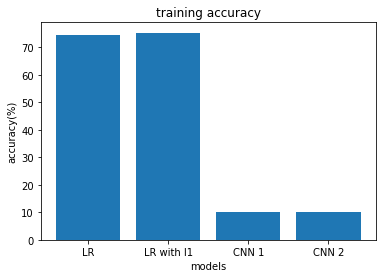

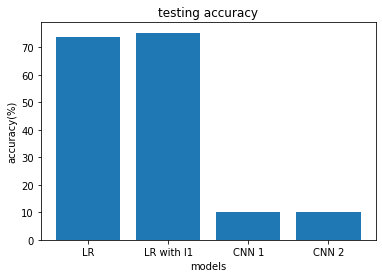

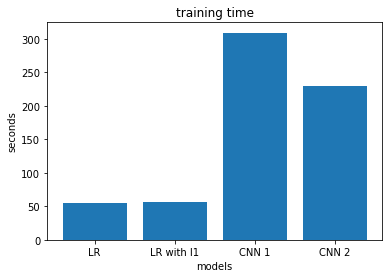

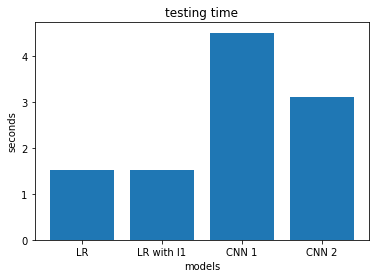

In [15]:
# bar graphs
models = ['LR', 'LR with l1', 'CNN 1', 'CNN 2']
train_acc = [LR1_train_accuracy, LR2_test_accuracy, CNN1_train_accuracy, CNN2_train_accuracy]
test_acc = [LR1_test_accuracy, LR2_test_accuracy, CNN1_test_accuracy, CNN2_test_accuracy]
train_time = [LR1_train_time, LR2_train_time, CNN1_train_time, CNN2_train_time]
test_time = [LR1_test_time, LR2_test_time, CNN1_test_time, CNN2_test_time]

plt.bar(models, train_acc)
plt.xlabel('models')
plt.ylabel('accuracy(%)')
plt.title('training accuracy')
plt.show()

plt.bar(models, test_acc)
plt.xlabel('models')
plt.ylabel('accuracy(%)')
plt.title('testing accuracy')
plt.show()

plt.bar(models, train_time)
plt.xlabel('models')
plt.ylabel('seconds')
plt.title('training time')
plt.show()

plt.bar(models, test_time)
plt.xlabel('models')
plt.ylabel('seconds')
plt.title('testing time')
plt.show()

# observations
1. It is interesting that the logistic regression with l1 regularisation has higher accuracy on training data than the one without regularisation. Regularisation is used to avoid overfitting so the training accuracy of ridge regression must be lower than that of logistic regression without regularisation.
2. Both of the CNN models have 6 layers. The one with 4 convolutional layers and 2 fully connected layers takes more time training than the other one with 2 convolutional layers and 4 fully connected layers.

In [16]:
# select class 2 and 5
idx = torch.as_tensor(training_data.targets) == 2
idx += torch.as_tensor(training_data.targets) == 5
dset_train = torch.utils.data.dataset.Subset(training_data, np.where(idx==1)[0])
trainloader = torch.utils.data.DataLoader(dset_train, batch_size=batch_size, shuffle=True)

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=1), # (28-4+2*1)/2 + 1
            # 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=2, stride=2, padding=1), # (14-2+2*1)/2 + 1
            # 32, 8, 8
            nn.ReLU(),
            nn.Conv2d(32, 64, 2, stride=2, padding=1), # (8-2+2)/2 + 1
            # 64, 5, 5
            nn.ReLU(),
            nn.Conv2d(64, 128, 3) # (5-3)/1 + 1
            # 128, 3, 3
            
        )
        # out = (in - 1) * stride - 2*padding + outpadding + 1 + dilation(1)*(kernalsize - 1)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3),  # (3-1)*1 - 2*0 + 1 + 2 = 5
            # 64, 5, 5
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=2, output_padding=1), # (5-1)*2 -2*2 + 1 + 2 = 8
            # 32, 8, 8
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2, padding=1, output_padding=0), # (8-1)*2 - 2*1 + 1 + 1 = 14
            nn.ReLU(),
            # 16, 14, 14
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, output_padding=0), # (14-1)*2 - 2*1 + 1 + 3 = 28
            # 1, 28, 28
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [18]:
ae = Autoencoder()
ae_loss = nn.MSELoss()
optimiser = torch.optim.Adam(ae.parameters(), lr=lr_rate, weight_decay=1e-5)
ae_epoch = 10

In [19]:
# train the model
ae_result = []
losses=[]
for epoch in range(ae_epoch):
    for (imgs, labels) in trainloader:
        optimiser.zero_grad()
        recon = ae(imgs)
        loss = ae_loss(recon, imgs)
        loss.backward()
        optimiser.step()
    print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
    losses.append(float(loss))
    if epoch == 9:
        ae_result.append((labels, recon, imgs))

Epoch:1, Loss:0.0227
Epoch:2, Loss:0.0177
Epoch:3, Loss:0.0124
Epoch:4, Loss:0.0110
Epoch:5, Loss:0.0101
Epoch:6, Loss:0.0080
Epoch:7, Loss:0.0144
Epoch:8, Loss:0.0117
Epoch:9, Loss:0.0081
Epoch:10, Loss:0.0086


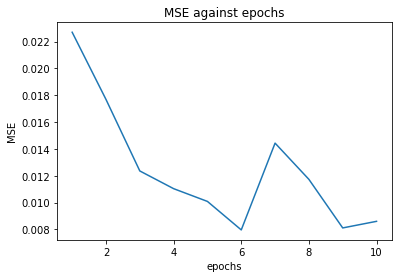

In [20]:
x_axis = np.arange(1,11,1)
plt.plot(x_axis, losses)
plt.title('MSE against epochs')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.show()

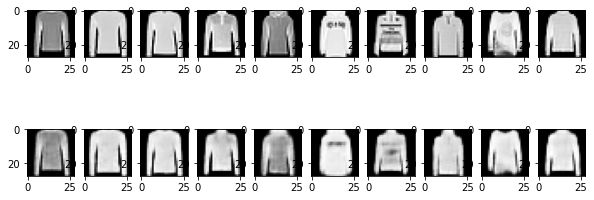

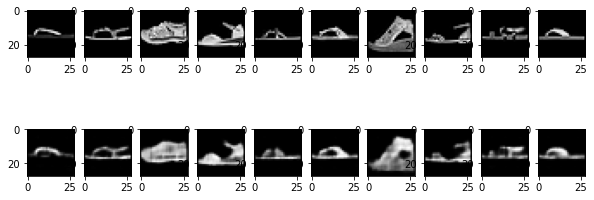

In [21]:
# plot class 2
plt.figure(figsize=(10,4))
breakpoint=0
for (imgs, labels) in trainloader:
    for i in range(len(labels)):
        if breakpoint < 10:
            if labels[i] == 2:
                breakpoint += 1
                plt.subplot(2, 10, breakpoint)
                plt.imshow(imgs[i].reshape(28,28), cmap='gray')
                reconstruction = ae(imgs[i].view(1, 1, 28, 28))
                plt.subplot(2, 10, breakpoint+10)
                plt.imshow(reconstruction.detach().numpy().reshape(28,28), cmap='gray')
# plot class 5                
plt.figure(figsize=(10,4))
breakpoint=0
for (imgs, labels) in trainloader:
    for i in range(len(labels)):
        if breakpoint < 10:
            if labels[i] == 5:
                breakpoint += 1
                plt.subplot(2, 10, breakpoint)
                plt.imshow(imgs[i].reshape(28,28), cmap='gray')
                reconstruction = ae(imgs[i].view(1, 1, 28, 28))
                plt.subplot(2, 10, breakpoint+10)
                plt.imshow(reconstruction.detach().numpy().reshape(28,28), cmap='gray')                

# observations
1. The reconstructions of the images have similar shape with the true images.
2. The MSE loss at the 4th epoch is less than at the last epoch